In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
import time
!git clone https://github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'MOD2NN'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 347 (delta 203), reused 247 (delta 119), pack-reused 0
Receiving objects: 100% (347/347), 8.20 MiB | 21.86 MiB/s, done.
Resolving deltas: 100% (203/203), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import time
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from cxlayers import InputToCx, CxMO, AngularSpectrum, CxD2NNIntensity, D2NNMNISTDetector, ImageResizing, ImageBinarization, D2NNMNISTFilter, CxD2NNFaradayRotation, Polarizer

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.8.0
Python: 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


shape : ((rcp or lcp), (x_real, x_image, y_real, y_image), width, height)
右ねじが進む方向で正

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
def loss(y_hat, y):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_hat, logits=y)


def loss_MSE(y_hat, y):
    return tf.reduce_sum((y_hat - y) ** 2)

In [4]:
#@title デフォルトのタイトル テキスト
wavelength = 531.0e-9 #@param {type:"number"}
d = 2.0e-6 #@param {type:"number"}

### 全結合条件

In [ ]:
theta = np.arcsin(wavelength/(2*d))
z = np.sqrt((100*d)**2 + (100*d)**2)/np.tan(theta)
z

0.0005135437489912859

In [8]:
from re import X
shape = (100, 100)

inputs = tf.keras.Input((28, 28))
x = ImageResizing(shape)(inputs)
x = ImageBinarization(0.5, 0.0, 1.0)(x)
x = InputToCx(shape)(x)
x = CxMO(shape, limitation='sin', limitation_num=2.1*np.pi/180)(x)
x = AngularSpectrum(shape, wavelength, 0.5e-3, d=d, normalization='max', method='band_limited')(x)
x = CxMO(shape, limitation='sin', limitation_num=2.1*np.pi/180)(x)
x = AngularSpectrum(shape, wavelength, 2.0e-3, d=d, normalization='max', method='band_limited')(x)
x = Polarizer(shape, phi=-45*np.pi/180, trainable=True)(x)
x = CxD2NNIntensity(shape, normalization='max')(x)
x = D2NNMNISTDetector(10, activation='softmax')(x)
model = tf.keras.Model(inputs, x)
model.summary()
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",  # category: sparse_categorical_crossentropy
              metrics=['accuracy'])

epochs = 20
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    min_delta=0.05,
    patience=2,
)

model_name = "20220330_3"

checkpoint_path = "/content/drive/MyDrive/D2NN/checkpoint/"+model_name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# チェックポイントコールバックを作る
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

result = model.fit(x_train,
                   y_train,
                   batch_size=64,
                   epochs=epochs,
                   callbacks=[cp_callback]
                   )

path = "/content/drive/MyDrive/D2NN/trained_model/" + model_name
model.save(path)

df = pd.DataFrame(result.history)
df.to_csv(path + "/history.csv")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_2 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 image_binarization_2 (Image  (None, 100, 100)         0         
 Binarization)                                                   
                                                                 
 input_to_cx_2 (InputToCx)   (None, 2, 2, 100, 100)    0         
                                                                 
 cx_mo_4 (CxMO)              (None, 2, 2, 100, 100)    10000     
                                                                 
 angular_spectrum_4 (Angular  (None, 2, 2, 100, 100)   0   

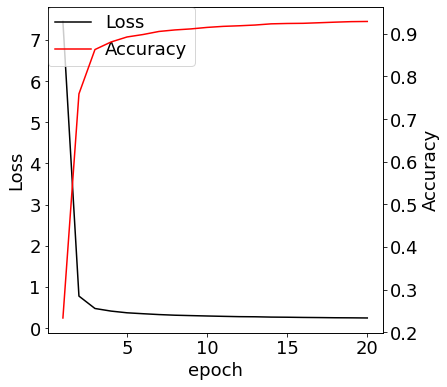

In [9]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, epochs + 1), result.history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, epochs + 1), result.history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

In [ ]:
model.evaluate(x_test, y_test)

2022-03-16 12:02:32.917280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 57s 180ms/step - loss: 0.5076 - accuracy: 0.8537


[0.5075562000274658, 0.8537000417709351]

In [10]:
layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)

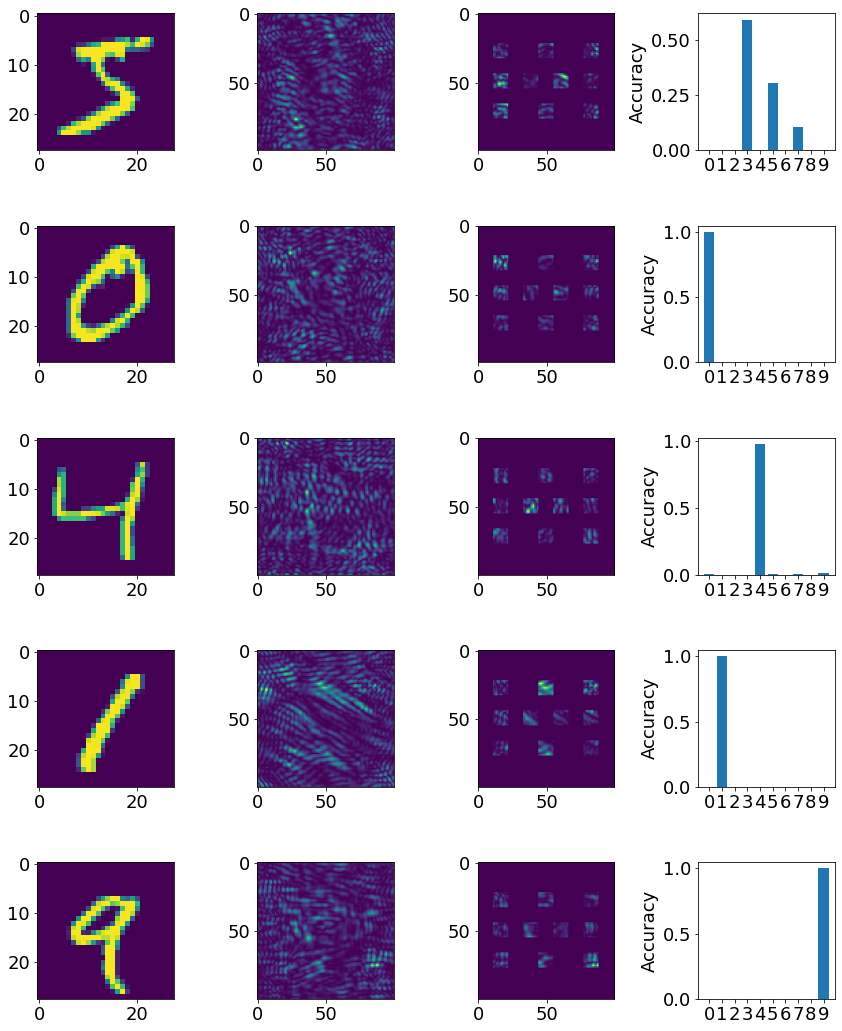

In [11]:
num = 5
images = x_train[0:num, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 3 * num))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_ylabel('Accuracy')
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
fig.tight_layout()

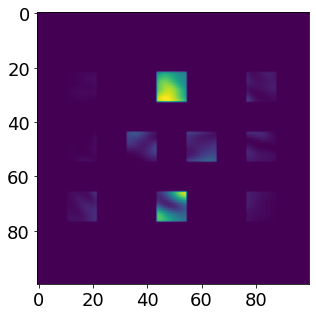

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(filtered_images[0,:,:])

In [ ]:
layer_outputs = [layer.output for layer in model.layers[1:]]
layer_outputs

In [ ]:
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
activation_model.summary()

In [ ]:
num = 5
images = x_train[0:num, :, :]
activations = activation_model.predict(images)
len(activations)

In [ ]:
fig, axes = plt.subplots(num, len(activations) - 2, figsize=(2 * len(activations) - 1, 2 * num))
for i in range(len(activations) - 2):
    layer_activation = activations[i]
    for j in range(num):
        intensity = tf.sqrt(layer_activation[j, 0, :, :] ** 2 + layer_activation[j, 1, :, :] ** 2)
        axes[j, i].imshow(intensity)

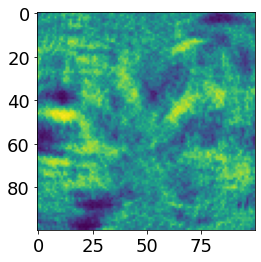

In [ ]:
plt.imshow(tf.tanh(model.layers[5].get_weights()[0]))

AttributeError: 'Resizing' object has no attribute 'adapt'

In [ ]:
processing = tf.keras.layers.experimenta.procesing

inputs = tf.keras.Input((28, 28))

x = ImageResize((100, 100))(inputs)
x = InputToCx((100, 100))(x)
x = CxMO((100, 100))(x)
x = FreeSpacePropagation((100, 100), 2*np.pi/633e-9, 0.5e-3)(x)
x = CxD2NNIntensity((100, 100))(x)
x = D2NNMNISTDetector(10)(x)

model = tf.keras.Model(inputs, x)
model.summary()

inputtocx: 0.011839791999818772
propagation: 0.030384291000018493
intensity: 0.010773833000030208
detector: 0.005371208000042316
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resize_2 (ImageResize  (None, 100, 100)         0         
 )                                                               
                                                                 
 input_to_cx_2 (InputToCx)   (None, 2, 4, 100, 100)    0         
                                                                 
 cx_mo (CxMO)                (None, 2, 4, 100, 100)    10000     
                                                                 
 free_space_propagation_2 (F  (None, 2, 4, 100, 100)   0         
 reeSpacePropagation)                                         

In [12]:
model.layers[-3].get_weights()[0] / np.pi * 180

array([-89.94155], dtype=float32)